<a href="https://colab.research.google.com/github/GBocca1/AI-caries/blob/main/AI_carie_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("CUDA disponibile:", torch.cuda.is_available())
print("Nome GPU:", torch.cuda.get_device_name(0))


CUDA disponibile: True
Nome GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/dental-bitewing-x-ray-dataset"
print(os.listdir(dataset_path))


['labelmap.txt', 'annotations', 'images', 'caries_annotations']


Image shape:  (660, 844)


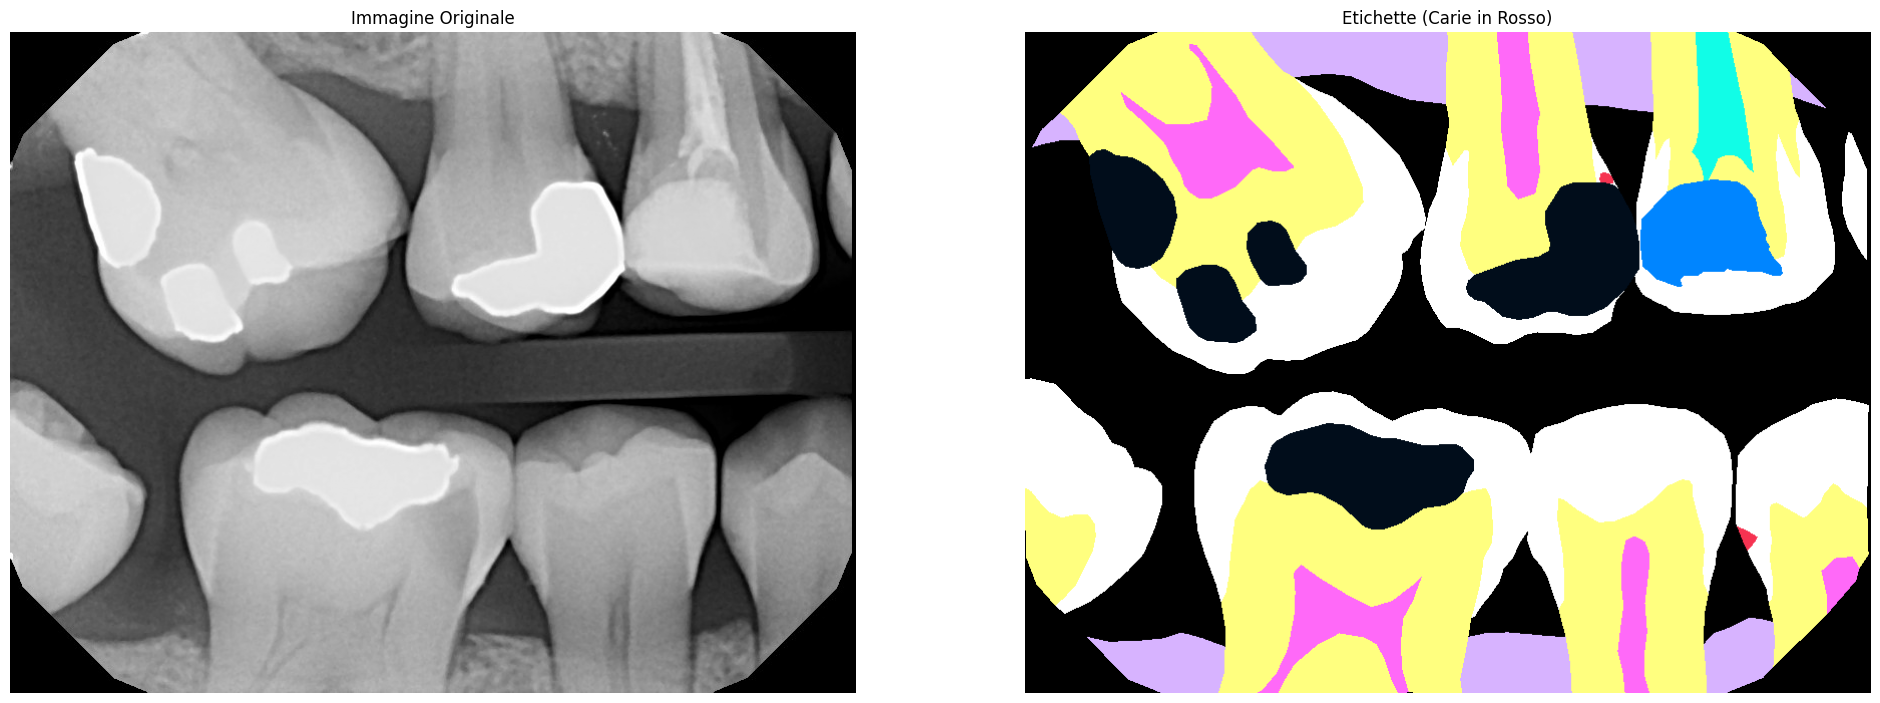

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = os.path.join(dataset_path, "images", "X07848.JPG")
mask_path = os.path.join(dataset_path, "annotations", "X07848.png")

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

print("Image shape: ", img.shape)

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Immagine Originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Etichette (Carie in Rosso)")
plt.axis("off")
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class DentalCariesDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # Lista di file immagini .JPG
        self.image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        mask_name = image_name.replace(".JPG", ".png")
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Carica immagine
        image = Image.open(image_path).convert("RGB")

        # Label = 1 se esiste la carie (cavity), altrimenti 0
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("RGB")
            mask_np = np.array(mask)
            carie_rgb = np.array([246, 51, 81])
            has_carie = np.any(np.all(mask_np == carie_rgb, axis=-1))
            label = int(has_carie)
        else:
            label = 0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
from torch.utils.data import random_split
from matplotlib import pyplot as plt

images_path = "/content/drive/MyDrive/dental-bitewing-x-ray-dataset/images"
masks_path = "/content/drive/MyDrive/dental-bitewing-x-ray-dataset/annotations"

# --- Dataset completo ---
full_dataset = DentalCariesDataset(images_dir=images_path, masks_dir=masks_path, transform=None)
img, label = full_dataset[0]
print(f"Nome della prima immagine: {full_dataset.image_files[0]}")
print(f"Etichetta della prima immagine: {label}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split manuale
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Nome della prima immagine: X08119_1.JPG
Etichetta della prima immagine: 0


100%|██████████| 1007/1007 [00:38<00:00, 26.04it/s]


🔍 Totale immagini: 1007
🦷 Con carie (label=1): 399
✅ Senza carie (label=0): 608


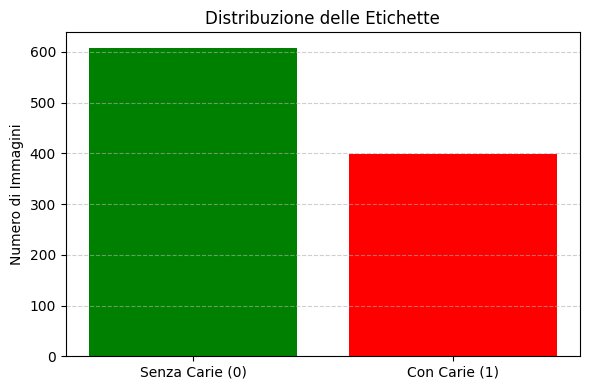

In [ ]:
from collections import Counter
from tqdm import tqdm  # opzionale, solo per barra di avanzamento

labels = []

# Scorri tutto il dataset per estrarre le etichette
for i in tqdm(range(len(full_dataset))):
    _, label = full_dataset[i]
    labels.append(label.item())

# Conta quante 0 e quante 1
counts = Counter(labels)

print(f"🔍 Totale immagini: {len(full_dataset)}")
print(f"🦷 Con carie (label=1): {counts[1]}")
print(f"✅ Senza carie (label=0): {counts[0]}")

plt.figure(figsize=(6, 4))
plt.bar(['Senza Carie (0)', 'Con Carie (1)'], [counts[0], counts[1]], color=['green', 'red'])
plt.title('Distribuzione delle Etichette')
plt.ylabel('Numero di Immagini')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # più casuale
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import DataLoader

# Applica le trasformazioni personalizzate post-split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# --- 4. DataLoader ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet50_Weights

# Carica ResNet50 pre-addestrata
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Sblocca solo gli ultimi blocchi per il fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Sostituisci l'ultimo layer per la classificazione binaria
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # output: 2 classi

# Porta il modello sulla GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Loss bilanciata
class_weights = torch.tensor([1.0, 608 / 399], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Ottimizzatore (solo fc se parametri congelati)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


In [ ]:
if torch.cuda.is_available():
    print("✅ GPU disponibile:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU non disponibile. Stai usando la CPU.")


✅ GPU disponibile: Tesla T4


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience          # quante epoche aspettare
        self.min_delta = min_delta        # miglioramento minimo accettabile
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
# --- Liste per metriche ---
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_loss = float('inf')
early_stopper = EarlyStopping(patience=7, min_delta=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_dataset)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- VALIDATION ---
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss = total_loss / len(val_dataset)
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- Early stopping ---
    early_stopper(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    if early_stopper.early_stop:
        print(f"✅ Early stopping attivato all’epoca {epoch+1}")
        break


Epoch 1/20 — Train Loss: 0.6726, Train Acc: 61.99% | Val Loss: 0.6801, Val Acc: 61.39%
Epoch 2/20 — Train Loss: 0.6671, Train Acc: 65.59% | Val Loss: 0.6823, Val Acc: 57.43%
Epoch 3/20 — Train Loss: 0.6638, Train Acc: 66.09% | Val Loss: 0.6817, Val Acc: 57.92%
Epoch 4/20 — Train Loss: 0.6605, Train Acc: 66.46% | Val Loss: 0.6772, Val Acc: 55.45%
Epoch 5/20 — Train Loss: 0.6557, Train Acc: 65.34% | Val Loss: 0.6769, Val Acc: 56.93%
Epoch 6/20 — Train Loss: 0.6528, Train Acc: 66.46% | Val Loss: 0.6773, Val Acc: 59.41%
Epoch 7/20 — Train Loss: 0.6472, Train Acc: 68.20% | Val Loss: 0.6747, Val Acc: 56.44%
Epoch 8/20 — Train Loss: 0.6436, Train Acc: 67.95% | Val Loss: 0.6689, Val Acc: 59.90%
Epoch 9/20 — Train Loss: 0.6409, Train Acc: 68.32% | Val Loss: 0.6691, Val Acc: 59.41%
Epoch 10/20 — Train Loss: 0.6386, Train Acc: 68.70% | Val Loss: 0.6696, Val Acc: 58.42%
Epoch 11/20 — Train Loss: 0.6368, Train Acc: 68.20% | Val Loss: 0.6713, Val Acc: 60.89%
Epoch 12/20 — Train Loss: 0.6334, Train A

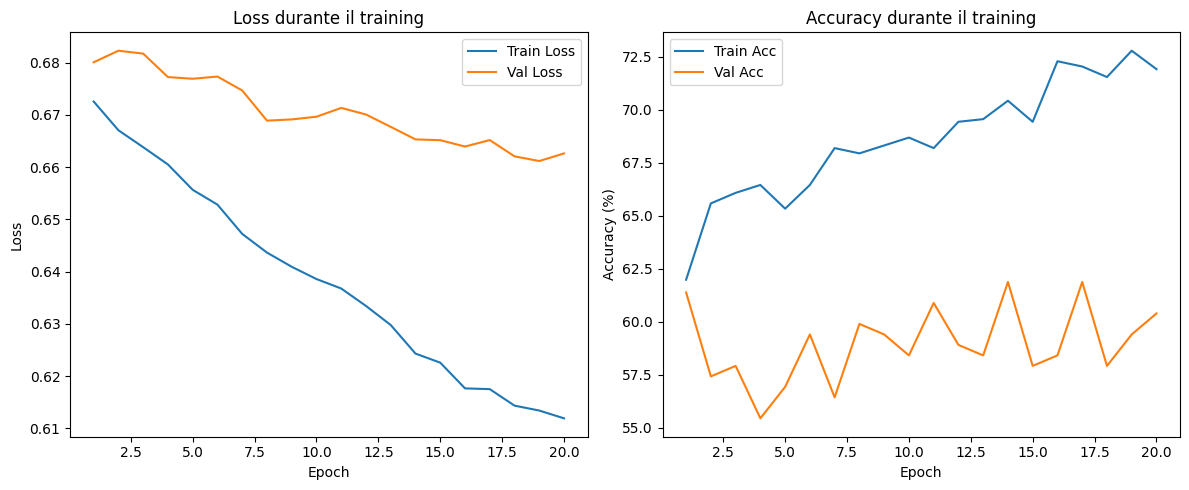

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# --- Grafico delle perdite ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss durante il training')
plt.legend()

# --- Grafico delle accuratezze ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy durante il training')
plt.legend()

plt.tight_layout()
plt.show()